In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

curr_dir = sys.path[0]
utils_dir = os.path.join(curr_dir.split("Amazon_VRP")[0], "utils")
if utils_dir not in sys.path:
    sys.path.append(utils_dir)
from util_func import get_dataset_dir


data_dir = get_dataset_dir("amazon_vrp")

In [2]:
# print file structure
print_folder = lambda x: print(f"\033[94m{x}\033[0m") # print in blue
print_file = lambda x: print(f"\033[92m{x}\033[0m") # print in green
def print_folder_structure(data_dir):
    for path, subdirs, files in os.walk(data_dir):
        layer = len(path.split(os.sep)) - len(data_dir.split(os.sep))
        print_folder("   "*layer + os.path.basename(path))
        for name in files:
            print_file("   "*(layer+1) + name)

print_folder_structure(data_dir)

amazon_vrp
   Readme.txt
   License.txt
   almrrc2021-data-evaluation
      model_score_inputs
         eval_actual_sequences.json
         eval_invalid_sequence_scores.json
      model_apply_inputs
         eval_route_data.json
         eval_package_data.json
         eval_travel_times.json
   almrrc2021-data-training
      model_score_inputs
         new_invalid_sequence_scores.json
         readme.md
         new_actual_sequences.json
      model_build_inputs
         invalid_sequence_scores.json
         package_data.json
         actual_sequences.json
         route_data.json
         readme.md
         travel_times.json
      model_build_outputs
         readme.md
      model_score_outputs
         readme.md
         scores.json
      model_score_timings
         model_apply_time.json
         model_build_time.json
         readme.md
      model_apply_inputs
         new_package_data.json
         readme.md
         new_travel_times.json
         new_route_data.json
      model_a

In [3]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    # Radius of the Earth in kilometers (mean value)
    radius = 6371.0
    
    # Calculate the distance
    distance = radius * c
    
    return distance

def distance_matrix_np(points):
    latitudes, longitudes = points.T
    
    # Create meshgrid of all pairs of latitudes and longitudes
    latitudes_matrix, longitudes_matrix = np.meshgrid(latitudes, longitudes)
    
    # Compute the distance matrix
    dist_matrix = haversine_vectorized(latitudes_matrix, longitudes_matrix, latitudes_matrix.T, longitudes_matrix.T)
    
    return dist_matrix

In [4]:
def df_safe_divide(df1, df2):
    return df1.div(df2).replace([np.inf, -np.inf, np.nan], 0)

In [5]:
fn = os.path.join(data_dir, "almrrc2021-data-evaluation", "model_apply_inputs", "eval_travel_times.json")
# load data from json file fn
with open(fn) as f:
    tdata = json.load(f)    
route_ids = list(tdata.keys())

fn = os.path.join(data_dir, "almrrc2021-data-evaluation", "model_apply_inputs", "eval_route_data.json")
# load data from json file fn
with open(fn) as f:
    rdata = json.load(f)

In [6]:
def compute_nonEuclidean(tdata, rdata, r_idx):
    T1 = pd.DataFrame.from_dict(tdata[r_idx], orient="index")

    stops = pd.DataFrame.from_dict(rdata[r_idx]["stops"], orient="index")
    T2 = distance_matrix_np(stops[['lat', 'lng']].values)
    T2 = pd.DataFrame(T2, index=stops.index, columns=stops.index)

    speed = df_safe_divide(T2, T1) * 3600 # km/h
    asymmetry = df_safe_divide(abs(speed - speed.T), (speed+speed.T)/2)
    return T1, T2, speed, asymmetry

def visual_nonEuclidean(speed, asymmetry, axs=None, cbar=False, title=False):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(16,8))


    ax = axs[0]
    im = ax.imshow(speed, cmap="RdBu_r", vmin=0, vmax=30)
    ax.axis('off')
    
    if cbar:
        cbar = ax.figure.colorbar(im, ax=ax, orientation="horizontal",
                              extend="max", fraction=0.05, pad=0.05, shrink=0.8)
    if title:
        ax.set_title("Speed (km/h)")

    ax = axs[1]
    im = ax.imshow(asymmetry, cmap="Greens", vmin=0, vmax=0.25)
    ax.axis('off')
    
    if cbar:
        cbar = ax.figure.colorbar(im, ax=ax, orientation="horizontal",
                              extend="max", fraction=0.05, pad=0.05, shrink=0.8)
    if title:
        ax.set_title("Asymmetry")

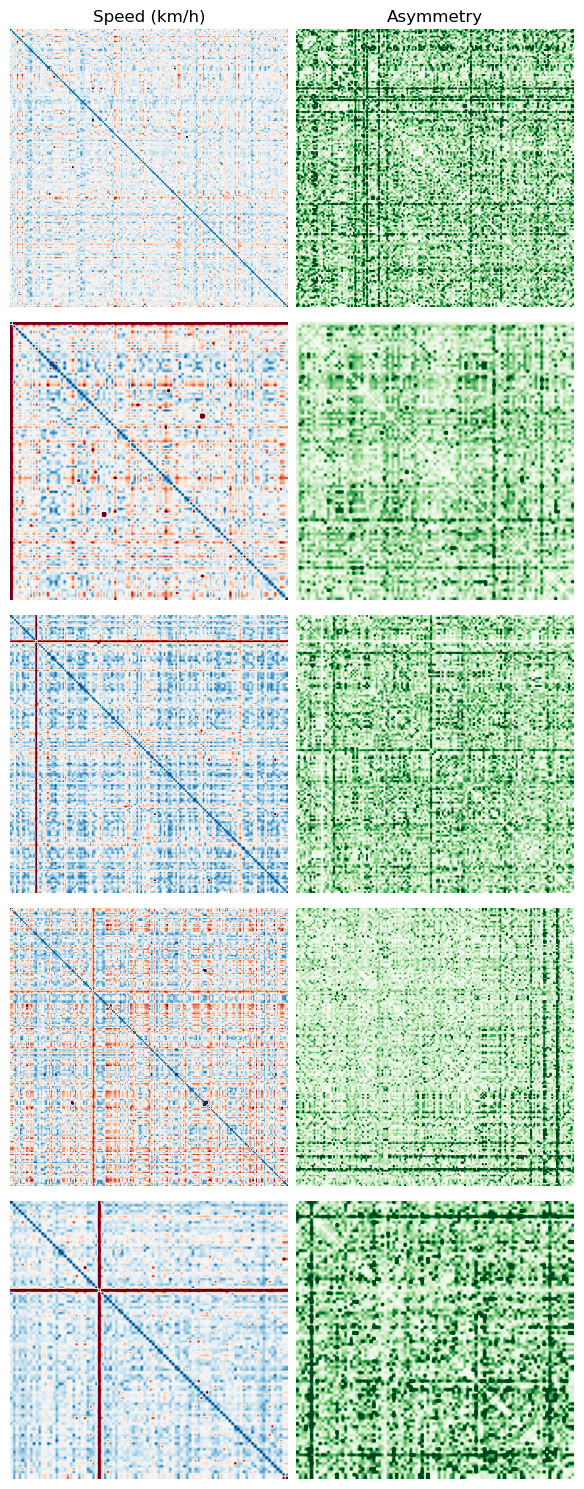

In [7]:
fig, axs = plt.subplots(5, 2, figsize=(6,15))

for i in range(5):
    r_idx = route_ids[i]
    T1, T2, speed, asymmetry = compute_nonEuclidean(tdata, rdata, r_idx)
    visual_nonEuclidean(speed, asymmetry,axs=axs[i,:], title=(i==0), cbar=False)

plt.tight_layout()

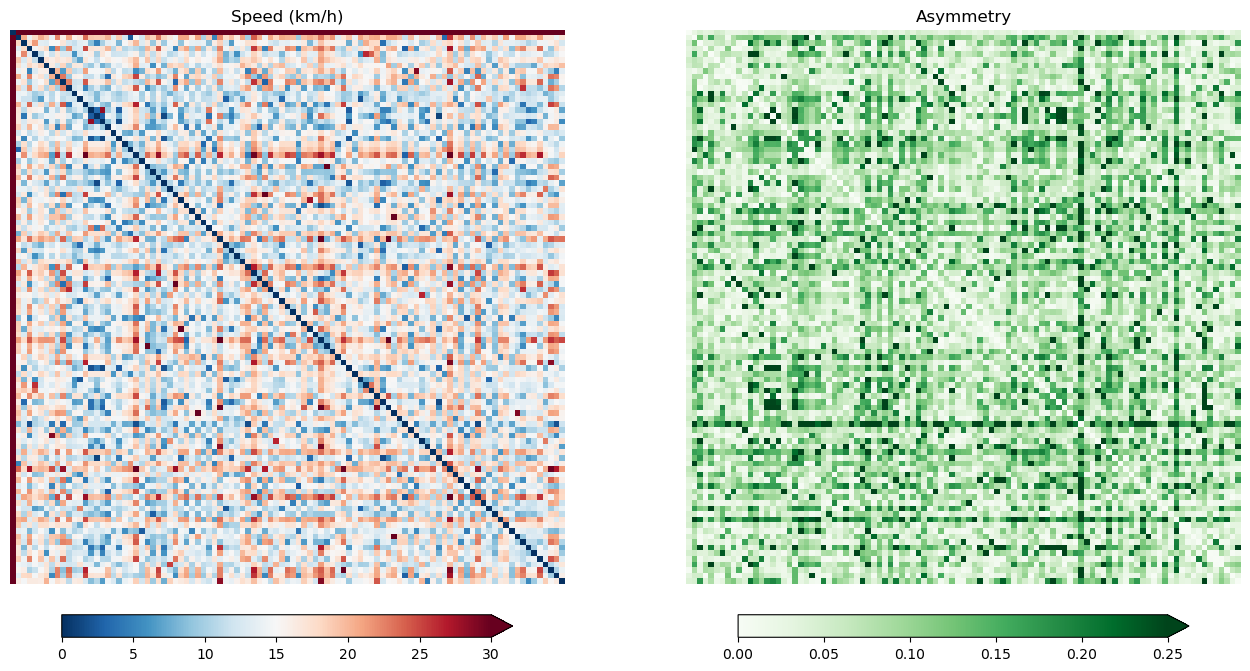

In [9]:
idx = 1
r_idx = route_ids[idx]
T1, T2, speed, asymmetry = compute_nonEuclidean(tdata, rdata, r_idx)
visual_nonEuclidean(speed, asymmetry, cbar=True, title=True)